In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report




import joblib
import json
import os
from datetime import datetime

In [2]:
# CONFIDENCE_THRESHOLD = 0.60 # Наш порог уверенности для принятия решения!

features_to_remove = ["day_of_year", "week_of_year", "month"]

# Исключить эти фичи

no_importen_features = []
# no_importen_features = ['month', 'day_of_week', 'relative_volume'] # Список самых неважных

features_to_remove = features_to_remove + no_importen_features
model_name = "random_forest_classifier_tbm10d" # ИМЯ МОДЕЛИ

In [3]:
# ==============================================================================
# ОСНОВНОЙ СКРИПТ МОДЕЛИРОВАНИЯ
# ==============================================================================

# --- ШАГ 1: Подготовка данных ---


data_folder = "../data/"
final_dataset_filename = 'moex_final_dataset.csv'
TARGET_COLUMN = 'tbm_10d' # Наша цель для предсказания!

# Загружаем финальный датасет
print(f"Загрузка данных из: {data_folder + final_dataset_filename}")
try:
    df = pd.read_csv(data_folder + final_dataset_filename)
    if features_to_remove:
        df = df.drop(columns=features_to_remove)
        print(f"Удалено {len(features_to_remove)} неважных признаков.")


    df['Date'] = pd.to_datetime(df['Date'])
    df.sort_values(by='Date', inplace=True)
    df.reset_index(drop=True, inplace=True)
    print("Данные успешно загружены.")
except FileNotFoundError:
    print("ОШИБКА: Финальный датасет не найден.")
    raise


print(f"\nИсходный размер датасета: {len(df)} строк.")
df.dropna(subset=[TARGET_COLUMN], inplace=True)
df.reset_index(drop=True, inplace=True)
print(f"Размер датасета после фильтрации по CUSUM-событиям: {len(df)} строк.")


# Определяем признаки (X) и цель (y)
# Исключаем все не-признаки: идентификаторы, дату и ВСЕ колонки с метками
tbm_cols = [col for col in df.columns if col.startswith('tbm_')]
cols_to_drop = ['Date', 'Ticker', 'Open', 'High', 'Low', 'Close', 'Volume'] + tbm_cols

feature_cols = [col for col in df.columns if col not in cols_to_drop]

X = df[feature_cols]
y = df[TARGET_COLUMN].astype(int)





print(f"\nЦелевая переменная (y): {TARGET_COLUMN}")
print(f"Количество признаков (X): {len(feature_cols)}")
print("Признаки:", feature_cols)

Загрузка данных из: ../data/moex_final_dataset.csv
Удалено 3 неважных признаков.
Данные успешно загружены.

Исходный размер датасета: 34775 строк.
Размер датасета после фильтрации по CUSUM-событиям: 29847 строк.

Целевая переменная (y): tbm_10d
Количество признаков (X): 242
Признаки: ['sarimax_pred_1d_to_today', 'sarimax_pi_width_rel_1d', 'sarimax_pred_3d_to_today', 'sarimax_pi_width_rel_3d', 'sarimax_pred_5d_to_today', 'sarimax_pi_width_rel_5d', 'sarimax_failed', 'sma_3', 'sma_5', 'sma_7', 'sma_10', 'sma_15', 'sma_20', 'sma_30', 'sma_40', 'sma_50', 'sma_70', 'sma_100', 'sma_150', 'sma_200', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'ADX_14', 'ADXR_14_2', 'DMP_14', 'DMN_14', 'rsi_5', 'rsi_7', 'rsi_14', 'rsi_21', 'rsi_30', 'rsi_50', 'STOCHk_14_3_3', 'STOCHd_14_3_3', 'STOCHh_14_3_3', 'willr_5', 'willr_7', 'willr_14', 'willr_21', 'willr_30', 'atr_5', 'atr_7', 'atr_14', 'atr_21', 'BBL_20_2.0_2.0', 'BBM_20_2.0_2.0', 'BBU_20_2.0_2.0', 'BBB_20_2.0_2.0', 'BBP_20_2.0_2.0', 'bb_width_nor

In [4]:
# --- ШАГ 2: Правильное разделение данных (Walk-Forward Validation) ---

# Мы будем использовать 5 "сдвигов". Модель будет обучаться на части данных,
# а тестироваться на следующем, более новом блоке.
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

print(f"\nНачинаем Walk-Forward валидацию с {n_splits} сплитами...")

# --- ШАГ 3: Обучение и оценка модели в цикле ---

all_scores = []

# для хранения детальных результатов
results_summary = pd.DataFrame(
    columns=['Split', 'Train Start', 'Train End', 'Test Start', 'Test End', 
             'Accuracy', 'Precision (Buy)', 'Recall (Buy)', 'F1-score (Buy)',
             'Precision (Sell)', 'Recall (Sell)', 'F1-score (Sell)']
)

for i, (train_index, test_index) in enumerate(tscv.split(X)):
    print(f"\n--- Сплит {i+1}/{n_splits} ---")
    
    # Разделяем данные на обучающую и тестовую выборки
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    print(f"Размер обучающей выборки: {len(X_train)}")
    print(f"Размер тестовой выборки: {len(X_test)}")
    
    # Инициализируем модель
    # class_weight='balanced' помогает модели лучше работать с несбалансированными классами
    # n_jobs=-1 использует все доступные ядра процессора для ускорения
    # model = RandomForestClassifier(
    #     n_estimators=100,      # Количество деревьев в лесу
    #     max_depth=10,          # Максимальная глубина каждого дерева
    #     random_state=42,       # Для воспроизводимости результатов
    #     class_weight='balanced',
    #     n_jobs=-1
    # )

    # Инициализируем НОВУЮ модель
    model = RandomForestClassifier(
        n_estimators=100, max_depth=10, random_state=42, class_weight='balanced', n_jobs=-1
    )
    # Обучаем модель
    print("Обучение модели...")
    model.fit(X_train, y_train)
    
    # Делаем предсказания
    print("Оценка модели...")
    y_pred = model.predict(X_test)
    # print("Получение вероятностей...")
    # y_pred_proba = model.predict_proba(X_test)
    
    # Создаем массив для новых предсказаний, по умолчанию '0' (Hold)
    # y_pred_filtered = np.zeros(len(y_test)) 

    # Где вероятность класса +1 > порога, ставим +1
    # buy_signals = y_pred_proba[:, 2] > CONFIDENCE_THRESHOLD 
    # y_pred_filtered[buy_signals] = 1

    # Где вероятность класса -1 > порога, ставим -1
    # ВАЖНО: y_pred_proba возвращает вероятности в порядке классов [-1, 0, 1]
    # Поэтому P(-1) это y_pred_proba[:, 0]
    # P(0)  это y_pred_proba[:, 1]
    # P(+1) это y_pred_proba[:, 2]
    # sell_signals = y_pred_proba[:, 0] > CONFIDENCE_THRESHOLD
    # y_pred_filtered[sell_signals] = -1
    
    # Оцениваем качество
    accuracy = accuracy_score(y_test, y_pred)
    # accuracy = accuracy_score(y_test, y_pred_filtered)
    all_scores.append(accuracy)
    
    print(f"\nТочность (Accuracy) на сплите {i+1}: {accuracy:.4f}")
    # print(f"\nТочность (Accuracy) на сплите {i+1} (с порогом {CONFIDENCE_THRESHOLD}): {accuracy:.4f}")
    
    # Выводим детальный отчет по качеству для каждого класса
    print("Детальный отчет по качеству (Classification Report):")
    print(classification_report(y_test, y_pred, target_names=['-1 (Sell)', '0 (Hold)', '1 (Buy)']))
    # print(classification_report(y_test, y_pred_filtered, target_names=['-1 (Sell)', '0 (Hold)', '1 (Buy)']))

    # --- Сбор данных для сводной таблицы ---
    # Получаем даты начала и конца для обучающей и тестовой выборок
    train_start_date = df.loc[train_index, 'Date'].min().strftime('%Y-%m-%d')
    train_end_date = df.loc[train_index, 'Date'].max().strftime('%Y-%m-%d')
    test_start_date = df.loc[test_index, 'Date'].min().strftime('%Y-%m-%d')
    test_end_date = df.loc[test_index, 'Date'].max().strftime('%Y-%m-%d')

    # Извлекаем метрики из отчета
    report = classification_report(y_test, y_pred, output_dict=True)
    # report = classification_report(y_test, y_pred_filtered, output_dict=True)
    buy_metrics = report.get('1', {})  # Используем .get() для безопасности, если класса нет
    sell_metrics = report.get('-1', {})

    # Создаем словарь с результатами для текущего сплита
    split_results = {
        'Split': i + 1,
        'Train Start': train_start_date,
        'Train End': train_end_date,
        'Test Start': test_start_date,
        'Test End': test_end_date,
        'Accuracy': accuracy,
        'Precision (Buy)': buy_metrics.get('precision'),
        'Recall (Buy)': buy_metrics.get('recall'),
        'F1-score (Buy)': buy_metrics.get('f1-score'),
        # 'Support (Buy)': buy_metrics.get('support'),
        'Precision (Sell)': sell_metrics.get('precision'),
        'Recall (Sell)': sell_metrics.get('recall'),
        'F1-score (Sell)': sell_metrics.get('f1-score'),
        # 'Support (Sell)': sell_metrics.get('support'),
    }

    results_summary.loc[i] = split_results





print("="*100)




print(f"\nСредняя точность по всем сплитам: {np.mean(all_scores):.4f}")



print("\n\n--- Сводная таблица результатов по сплитам ---")
# Округляем числовые колонки для лучшей читаемости
numeric_cols = results_summary.select_dtypes(include=np.number).columns
results_summary[numeric_cols] = results_summary[numeric_cols].round(3)
print(results_summary.to_string()) # .to_string() выведет всю таблицу без обрезки






Начинаем Walk-Forward валидацию с 5 сплитами...

--- Сплит 1/5 ---
Размер обучающей выборки: 4977
Размер тестовой выборки: 4974
Обучение модели...


/Users/beilakaliev/Library/Caches/pypoetry/virtualenvs/ml-modeling-TB8BmMSm-py3.12/lib/python3.12/site-packages/pandas/core/generic.py:2168: RuntimeWarning: overflow encountered in cast
  arr = np.asarray(values, dtype=dtype)


ValueError: Input X contains infinity or a value too large for dtype('float32').


--- Определение важности признаков ---
Переобучаем модель на всех доступных данных для получения наиболее стабильной оценки...
Топ-20 самых важных признаков:
                  feature  importance
41         BBB_20_2.0_2.0    0.017232
43          bb_width_norm    0.016892
77        turnover_sma_30    0.013664
75        turnover_sma_20    0.012161
23                 rsi_21    0.011953
73        turnover_sma_14    0.011557
71         turnover_sma_7    0.011126
69         turnover_sma_5    0.011020
24                 rsi_30    0.010459
79         day_range_norm    0.010202
223   momentum_sharpe_60d    0.009731
220          momentum_30d    0.009121
167         low_to_sma_70    0.008819
33               willr_30    0.008449
25                 rsi_50    0.008282
225  momentum_sharpe_100d    0.008231
19                 DMN_14    0.007887
163         low_to_sma_50    0.007841
171        low_to_sma_100    0.007835
18                 DMP_14    0.007435


/var/folders/lh/9k36l4vn35v4qnj9z669pmtc0000gn/T/ipykernel_88624/1390474786.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance.head(20), palette='viridis')


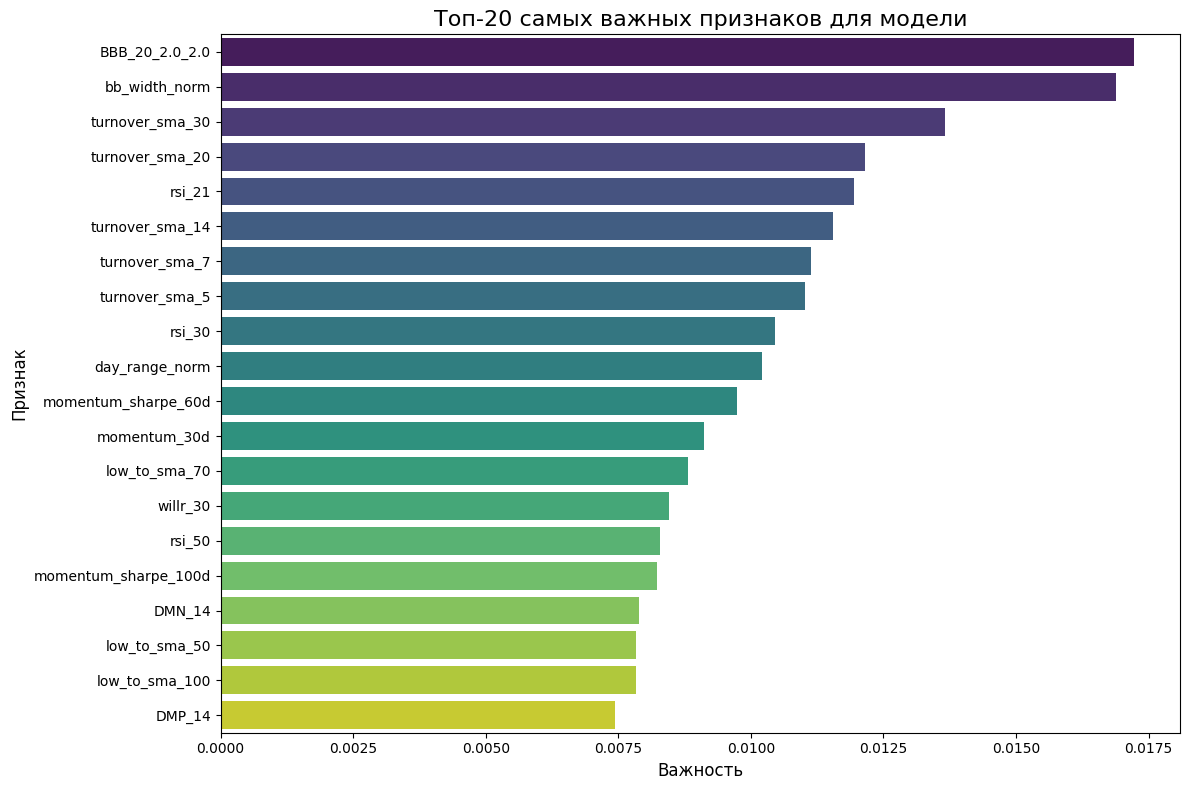

Топ-20 самых НЕ важных признаков:
                    feature  importance
184      sma50_above_sma200    0.000322
202  macd_hist_acceleration    0.000216
194        sma3_cross_sma10    0.000200
201       macd_cross_signal    0.000178
200              macd_state    0.000176
193        sma3_above_sma10    0.000146
190        sma7_above_sma15    0.000140
124          is_month_start    0.000138
191        sma7_cross_sma15    0.000134
206   cbr_rate_change_value    0.000121
127          is_quarter_end    0.000117
196         sma3_above_sma7    0.000084
207    cbr_rate_change_flag    0.000072
188       sma20_cross_sma50    0.000069
203       bb_upper_breakout    0.000068
204       bb_lower_breakout    0.000052
125            is_month_end    0.000034
185      sma50_cross_sma200    0.000025
182      sma70_cross_sma200    0.000009
126        is_quarter_start    0.000007


/var/folders/lh/9k36l4vn35v4qnj9z669pmtc0000gn/T/ipykernel_88624/1390474786.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance.tail(20), palette='viridis')


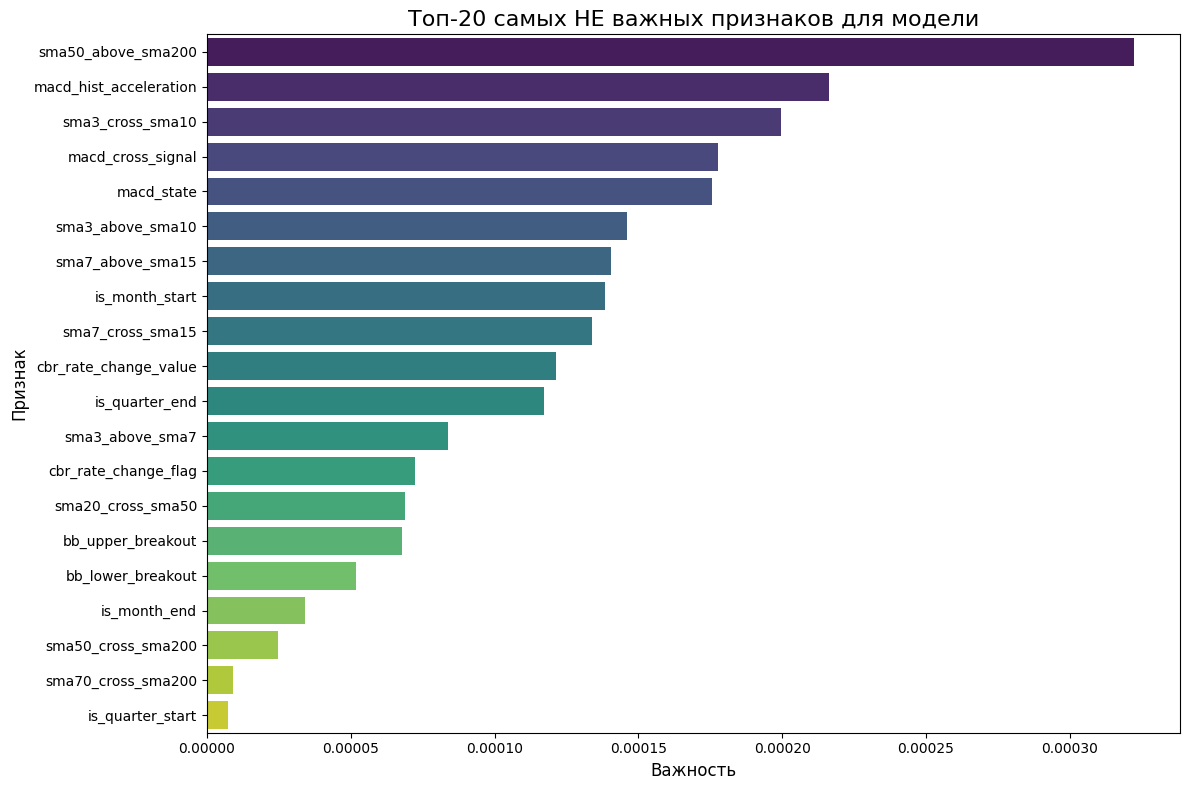

In [ ]:
# --- ШАГ 4: Анализ важности признаков ---

print("\n--- Определение важности признаков ---")
print("Переобучаем модель на всех доступных данных для получения наиболее стабильной оценки...")

# Обучаем финальную модель на всех данных
final_model = RandomForestClassifier(
    n_estimators=100, max_depth=10, random_state=42, class_weight='balanced', n_jobs=-1
)
final_model.fit(X, y)

# Создаем DataFrame с важностью признаков
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': final_model.feature_importances_ # метод - Mean Decrease in Impurity (Gini Importance)
}).sort_values('importance', ascending=False)

print("Топ-20 самых важных признаков:")
print(feature_importance.head(20))

# Визуализируем важность
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance.head(20), palette='viridis')
plt.title('Топ-20 самых важных признаков для модели', fontsize=16)
plt.xlabel('Важность', fontsize=12)
plt.ylabel('Признак', fontsize=12)
plt.tight_layout()
plt.show()


print("Топ-20 самых НЕ важных признаков:")
print(feature_importance.tail(20))
# Визуализируем важность
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance.tail(20), palette='viridis')
plt.title('Топ-20 самых НЕ важных признаков для модели', fontsize=16)
plt.xlabel('Важность', fontsize=12)
plt.ylabel('Признак', fontsize=12)
plt.tight_layout()
plt.show()


In [ ]:
# --- ШАГ 5: Сохранение артефактов модели ---

print("\n--- Сохранение артефактов модели ---")

output_folder = "../models/"

# timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
# filename_base = f"{model_name}_{timestamp}"
filename_base = model_name

# Создаем папку, если она не существует
os.makedirs(output_folder, exist_ok=True)
print(f"Артефакты будут сохранены в папку: {output_folder}")

# 1. Сохранение самой модели
model_path = os.path.join(output_folder, f"{filename_base}.joblib")
joblib.dump(final_model, model_path)
print(f"Модель сохранена в: {model_path}")

# 2. Сохранение списка признаков
features_path = os.path.join(output_folder, f"{filename_base}_features.json")
features_list = list(X.columns)
with open(features_path, 'w') as f:
    json.dump(features_list, f, indent=4)
print(f"Список признаков сохранен в: {features_path}")

# 3. Сохранение метаданных и результатов
metadata_path = os.path.join(output_folder, f"{filename_base}_metadata.json")

# Собираем все важные параметры и результаты в один словарь
metadata = {
    "model_name": model_name,
    "model_class": type(final_model).__name__,
    "training_timestamp_utc": datetime.utcnow().isoformat(),
    "target_column": TARGET_COLUMN,
    # "confidence_threshold": CONFIDENCE_THRESHOLD,
    "feature_engineering_file": "feature_engineering.py", # Указываем источник фичей
    "training_data_file": final_dataset_filename,
    "model_parameters": final_model.get_params(),
    "feature_importance": feature_importance.head(15).to_dict('records'),
    "cross_validation_summary": results_summary.to_dict('records')
}

with open(metadata_path, 'w', encoding='utf-8') as f:
    # Используем indent=4 для красивого форматирования, ensure_ascii=False для кириллицы
    json.dump(metadata, f, indent=4, ensure_ascii=False)


# 2. Сохранение списка признаков
features_path = os.path.join(output_folder, f"{filename_base}_features.json")
features_list = list(X.columns) 
with open(features_path, 'w') as f:
    json.dump(features_list, f, indent=4)
    
print(f"Список признаков сохранен в: {features_path}")
print(f"Метаданные и результаты сохранены в: {metadata_path}")

print("\nВсе артефакты модели успешно сохранены!")


--- Сохранение артефактов модели ---
Артефакты будут сохранены в папку: ../models/
Модель сохранена в: ../models/random_forest_classifier_tbm10d.joblib
Список признаков сохранен в: ../models/random_forest_classifier_tbm10d_features.json
Список признаков сохранен в: ../models/random_forest_classifier_tbm10d_features.json
Метаданные и результаты сохранены в: ../models/random_forest_classifier_tbm10d_metadata.json

Все артефакты модели успешно сохранены!


/var/folders/lh/9k36l4vn35v4qnj9z669pmtc0000gn/T/ipykernel_88624/3692246799.py:34: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "training_timestamp_utc": datetime.utcnow().isoformat(),
